# Machine Learning

In this file, instructions how to approach the challenge can be found.

We are going to work on different types of Machine Learning problems:

- **Regression Problem**: The goal is to predict delay of flights.
- **(Stretch) Multiclass Classification**: If the plane was delayed, we will predict what type of delay it is (will be).
- **(Stretch) Binary Classification**: The goal is to predict if the flight will be cancelled.

In [1]:
# import pandas
import pandas as pd
import numpy as np
import copy

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor, XGBClassifier, plot_importance
from sklearn.metrics import r2_score, mean_squared_error

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

C:\Users\cfsui\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Read Preprocessed Data

In [32]:
# load data
df = pd.read_csv("data/flights_preprocessed_42k.csv", index_col=0)
df.head(3)

,fl_date,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,dep_time,dep_delay,taxi_out,...,arr_hr_sin,arr_hr_cos,fl_mnth_sin,fl_mnth_cos,fl_wkday_sin,fl_wkday_cos,day_num_of_flights,num_flights_6hrs,inbound_fl_num,inbound_fl
0,2019-06-07,WN,N8683D,2784,12889,11066,1900-01-01 18:30:00,1825.0,-5.0,18.0,...,0.258819,0.965926,1.224647e-16,-1.000000,-0.433884,-0.900969,25,9,0,0
1,2019-07-26,B6,N535JB,1347,11278,14843,1900-01-01 08:00:00,808.0,8.0,15.0,...,0.258819,-0.965926,-5.000000e-01,-0.866025,-0.433884,-0.900969,4,2,0,0
2,2019-06-03,CP,N217NN,6092,12892,11292,1900-01-01 19:43:00,2014.0,31.0,14.0,...,-0.258819,0.965926,1.224647e-16,-1.000000,0.000000,1.000000,15,12,1,1


In [33]:
df.shape

(42127, 62)

In [34]:
# reset dtypes
categorical_features = ['op_unique_carrier',
                        'tail_num', 
                        'op_carrier_fl_num',
                        'origin_airport_id',
                        'dest_airport_id',
                        # 'share_code',
                        'origin_city',
                        'origin_state',
                        'dest_city',
                        'dest_state',
                        'fl_month',
                        'fl_weekday',
                        'season',
                        'inbound_fl']

df[categorical_features] = df[categorical_features].astype('str')
# df_train[categorical_features] = df_train[categorical_features].astype('str')
# df_test[categorical_features] =df_test[categorical_features].astype('str')

#### Transform Target Variable

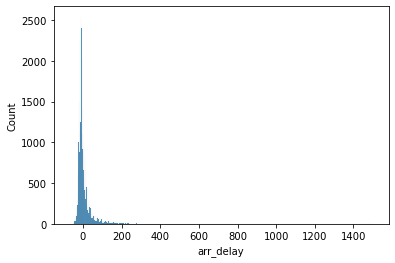

In [35]:
# target variable distribution
# left skewed with long tail
# target_train = df_train['arr_delay']
# target_test = df_test['arr_delay']
target = df['arr_delay']
sns.histplot(data=target)
plt.show()

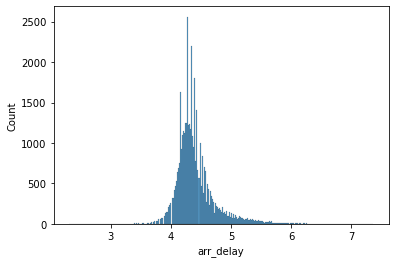

In [36]:
# target variable distribution after log transformation in training set
# If use transformed target variable to train, when evaluate prediction results, REMEMBER to transform predicted value back first
diff = df['arr_delay'].min() - 10 # min value of whole dataset
# target_train_log = np.log(target_train - diff)
target_log = np.log(target - diff)
sns.histplot(data=target_log)
plt.show()

In [37]:
# use target for this case
df['arr_delay'] = target_log

#### More Feature Engineering

##### Transform some new features by using 'arr_delay'

##### Target Encoding before splitting dataset

In [38]:
def leave_one_out_pct(df, i, d='arr_delay'):
    """
    Caculate group occurance percentage with cross calculation for interested categorical column, and imput leave_one_out_mean value into dataframe
    PARAMS:
        df (pd.DataFrame): 
        i (str): categorial independent variable
        d (str): dependent variable
    RETURNS (pd.Series):
        pandas series containing leave-one-out occurance percentage
    """
    data = df.copy()[[i, d]]
    group_ct = data.groupby(i, as_index=False).count().rename(columns={d: 'ct'})
    group_delay_ct = data[data[d] >= np.log(15 - diff)].groupby(i, as_index=False).count().rename(columns={d: 'delay_ct'})
    data = pd.merge(data, group_ct, how='left', on=i)
    data = pd.merge(data, group_delay_ct, how='left', on=i)
    data['leftout_pct'] = (data['delay_ct'] - 1) / (data['ct'] - 1)
        
    data = data.fillna(0)
    return data['leftout_pct']

In [39]:
def leave_one_out_mean(df, i, d='arr_delay'):
    """
    Caculate group means with cross calculation for interested categorical column, and imput leave_one_out_mean value into dataframe
    PARAMS:
        df (pd.DataFrame): 
        i (str): categorial independent variable
        d (str): dependent variable
    RETURNS (pd.Series):
        pandas series containing leave-one-out mean values
    """
    data = df.copy()[[i, d]]
    group_sum_count = data.groupby(i)[d].agg(['sum', 'count']).reset_index()
    data = pd.merge(data, group_sum_count, how='left', on=i)
    data['leftout_sum'] = data['sum'] - data[d]
    data['leftout_mean'] = data['leftout_sum'] / (data['count'] - 1)
    data = data.fillna(0)
    return data['leftout_mean']

In [40]:
df.shape

(42127, 62)

In [41]:
# calculate how many delay count percentage ('arr_delay' > 15) happened on each carrier/flight_num/tail_num/carrier/origin_airport/dest_airport/origin_city/origin_state/dest_city/dest_state 
# calculate average delay time of each ... (same as above)
# merge with df

tran_features = ['op_unique_carrier', 'tail_num',  'op_carrier_fl_num', 'origin_airport_id', 'dest_airport_id', 'origin_city', 'origin_state', 'dest_city', 'dest_state']

for col in tran_features:    
    df[f'{col}_leftout_pct'] = leave_one_out_pct(df, col)
    df[f'{col}_leftout_mean'] = leave_one_out_mean(df, col)
    

In [42]:
df.shape

(42127, 80)

In [43]:
df.iloc[:, -9:].isnull().sum()

dest_airport_id_leftout_mean    0
origin_city_leftout_pct         0
origin_city_leftout_mean        0
origin_state_leftout_pct        0
origin_state_leftout_mean       0
dest_city_leftout_pct           0
dest_city_leftout_mean          0
dest_state_leftout_pct          0
dest_state_leftout_mean         0
dtype: int64

## Main Task: Regression Problem

The target variable is **ARR_DELAY**. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of --> We can use average delay from earlier days but not the one from the actual flight we predict.  

For example, variables **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY** shouldn't be used directly as predictors as well. However, we can create various transformations from earlier values.

We will be evaluating your models by predicting the ARR_DELAY for all flights **1 week in advance**.

### Feature Selection / Dimensionality Reduction

### Modeling

Use different ML techniques to predict each problem.

- linear / logistic / multinomial logistic regression
- Naive Bayes
- Random Forest
- SVM
- XGBoost
- The ensemble of your own choice

#### XGBoost

In [44]:
df.columns

Index(['fl_date', 'op_unique_carrier', 'tail_num', 'op_carrier_fl_num',
       'origin_airport_id', 'dest_airport_id', 'crs_dep_time', 'dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in',
       'crs_arr_time', 'arr_time', 'arr_delay', 'cancelled',
       'cancellation_code', 'diverted', 'crs_elapsed_time',
       'actual_elapsed_time', 'air_time', 'distance', 'carrier_delay',
       'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay',
       'first_dep_time', 'total_add_gtime', 'longest_add_gtime', 'share_code',
       'origin_city', 'origin_state', 'dest_city', 'dest_state', 'arr_date',
       'dep_datetime', 'arr_datetime', 'fl_month', 'fl_weekday', 'season',
       'dep_min_of_day', 'arr_min_of_day', 'dep_hr', 'arr_hr', 'dep_min_sin',
       'dep_min_cos', 'dep_hr_sin', 'dep_hr_cos', 'arr_min_sin', 'arr_min_cos',
       'arr_hr_sin', 'arr_hr_cos', 'fl_mnth_sin', 'fl_mnth_cos',
       'fl_wkday_sin', 'fl_wkday_cos', 'day_num_of_flights'

In [45]:
df.head()

,fl_date,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,dep_time,dep_delay,taxi_out,...,dest_airport_id_leftout_pct,dest_airport_id_leftout_mean,origin_city_leftout_pct,origin_city_leftout_mean,origin_state_leftout_pct,origin_state_leftout_mean,dest_city_leftout_pct,dest_city_leftout_mean,dest_state_leftout_pct,dest_state_leftout_mean
0,2019-06-07,WN,N8683D,2784,12889,11066,1900-01-01 18:30:00,1825.0,-5.0,18.0,...,0.189591,4.428604,0.204225,4.430758,0.190772,4.420726,0.193333,4.428913,0.202454,4.420298
1,2019-07-26,B6,N535JB,1347,11278,14843,1900-01-01 08:00:00,808.0,8.0,15.0,...,0.226950,4.480207,0.185584,4.401217,0.185584,4.401217,0.226950,4.480207,0.246753,4.482764
2,2019-06-03,CP,N217NN,6092,12892,11292,1900-01-01 19:43:00,2014.0,31.0,14.0,...,0.182115,4.415133,0.184659,4.390099,0.180026,4.406197,0.182115,4.415133,0.180980,4.416226
3,2018-05-09,CP,N614CZ,5823,12889,14831,1900-01-01 10:15:00,1005.0,-10.0,12.0,...,0.157895,4.384688,0.204225,4.430918,0.190772,4.420867,0.157895,4.384688,0.198671,4.407906
4,2019-09-21,DL,N905DL,1281,10397,13244,1900-01-01 15:02:00,1503.0,1.0,11.0,...,0.178571,4.378191,0.170505,4.403825,0.170877,4.404697,0.178571,4.378191,0.157333,4.395858


In [46]:
avail_features = [
    # 'fl_date',
    # 'op_unique_carrier',
    # 'tail_num', 
    # 'op_carrier_fl_num',
    # 'origin_airport_id',
    # 'dest_airport_id',
    # 'crs_dep_time',
    # 'crs_arr_time',
    # 'crs_elapsed_time',
    'distance',
    'share_code',
    # 'origin_city',
    # 'origin_state',
    # 'dest_city',
    # 'dest_state',
    # 'arr_date',
    # 'dep_datetime',
    # 'arr_datetime',
    # 'fl_month',
    # 'fl_weekday',
    # 'season',
    # 'day_num_of_flights',
    'num_flights_6hrs',
    'inbound_fl_num',
    # 'inbound_fl',
    # 'dep_min_of_day',
    # 'arr_min_of_day',
    # 'dep_hr',
    # 'arr_hr',
    'arr_min_sin',
    'arr_min_cos',
    # 'arr_hr_sin',
    # 'arr_hr_cos',
    'dep_min_sin', 
    'dep_min_cos', 
    # 'dep_hr_sin', 
    # 'dep_hr_cos',
    'fl_mnth_sin', 
    'fl_mnth_cos',
    'fl_wkday_sin',
    'fl_wkday_cos',
    'op_unique_carrier_leftout_pct',
    'op_unique_carrier_leftout_mean',
    # 'tail_num_leftout_pct', 
    # 'tail_num_leftout_mean',
    # 'op_carrier_fl_num_leftout_pct',
    'op_carrier_fl_num_leftout_mean',
    # 'origin_airport_id_leftout_pct', 
    'origin_airport_id_leftout_mean',
    # 'dest_airport_id_leftout_pct',
    # 'dest_airport_id_leftout_mean',
    # 'origin_city_leftout_pct',
    # 'origin_city_leftout_mean',
    # 'origin_state_leftout_pct', 
    'origin_state_leftout_mean',
    # 'dest_city_leftout_pct', 
    # 'dest_city_leftout_mean',
    # 'dest_state_leftout_pct',
    'dest_state_leftout_mean'
]

In [47]:
X_train, X_test, y_train, y_test = train_test_split(df[avail_features], df['arr_delay'], train_size=0.7, test_size=0.3, random_state=888)

xg_reg = XGBRegressor(objective ='reg:squarederror',
                      learning_rate = 0.05,
                      max_depth = 3,
                      # reg_lambda = 15,
                      # gamma = 10,
                      n_estimators = 150)
xg_reg.fit(X_train, y_train)
y_pred = xg_reg.predict(X_test)
# y_pred = np.exp(xg_reg.predict(X_test)) + diff

In [48]:
r2_score(y_test, y_pred)

0.5425405560035701

In [49]:
xg_reg.score(X_train, y_train)

0.5545296165585925

#### Predict

In [54]:
# read test file
df_pred = pd.read_csv('data/flights_test_preprocessed.csv', index_col=0)

# reset dtypes
categorical_features = ['op_unique_carrier',
                        'tail_num', 
                        'op_carrier_fl_num',
                        'origin_airport_id',
                        'dest_airport_id',
                        # 'share_code',
                        'origin_city',
                        'origin_state',
                        'dest_city',
                        'dest_state',
                        'fl_month',
                        'fl_weekday',
                        'season',
                        'inbound_fl']
df_pred[categorical_features] = df_pred[categorical_features].astype('str')

# Feature imputation
# add features to predict set with values computed by above dataset
# for example, flight No.#### used to have 7 delays in training set, then add 7 to same flight No. in test set
# assign 7 to flight No.##### in this example
feature_add = [['op_unique_carrier', 'op_unique_carrier_leftout_pct', 'op_unique_carrier_leftout_mean'],
               ['tail_num', 'tail_num_leftout_pct', 'tail_num_leftout_mean'],
               ['op_carrier_fl_num', 'op_carrier_fl_num_leftout_pct', 'op_carrier_fl_num_leftout_mean'],
               ['origin_airport_id', 'origin_airport_id_leftout_pct', 'origin_airport_id_leftout_mean'],
               ['dest_airport_id', 'dest_airport_id_leftout_pct', 'dest_airport_id_leftout_mean'],
               ['origin_city', 'origin_city_leftout_pct', 'origin_city_leftout_mean'],
               ['origin_state', 'origin_state_leftout_pct', 'origin_state_leftout_mean'],
               ['dest_city', 'dest_city_leftout_pct', 'dest_city_leftout_mean'],
               ['dest_state', 'dest_state_leftout_pct', 'dest_state_leftout_mean']]
              
delay_mean = np.log(df['arr_delay'].mean() - diff)

for cols in feature_add:
    cats_means = df[cols].groupby(cols[0], as_index=False).mean()
    df_pred = pd.merge(df_pred, cats_means, on=cols[0], how='left').fillna(delay_mean)

In [55]:
X_pred = df_pred[avail_features]
y_pred = np.exp(xg_reg.predict(X_pred)) + diff # transform back

In [72]:
df_pred.head()

,fl_date,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,dest_airport_id,crs_dep_time,crs_arr_time,crs_elapsed_time,distance,...,dest_airport_id_leftout_mean,origin_city_leftout_pct,origin_city_leftout_mean,origin_state_leftout_pct,origin_state_leftout_mean,dest_city_leftout_pct,dest_city_leftout_mean,dest_state_leftout_pct,dest_state_leftout_mean,predicted_delay
0,2020-01-01,WN,N951WN,5888,13891,14771,1900-01-01 18:10:00,1900-01-01 19:45:00,95,363,...,4.437163,0.075581,4.367186,0.180026,4.40628,0.256044,4.437163,0.198671,4.407851,2.135284
1,2020-01-01,WN,N467WN,6276,13891,14771,1900-01-01 11:50:00,1900-01-01 13:20:00,90,363,...,4.437163,0.075581,4.367186,0.180026,4.40628,0.256044,4.437163,0.198671,4.407851,2.041267
2,2020-01-01,WN,N7885A,4598,13891,14831,1900-01-01 20:20:00,1900-01-01 21:30:00,70,333,...,4.384030,0.075581,4.367186,0.180026,4.40628,0.157895,4.384030,0.198671,4.407851,2.135284
3,2020-01-01,WN,N551WN,4761,13891,14831,1900-01-01 13:40:00,1900-01-01 14:55:00,75,333,...,4.384030,0.075581,4.367186,0.180026,4.40628,0.157895,4.384030,0.198671,4.407851,2.135284
4,2020-01-01,WN,N968WN,5162,13891,14831,1900-01-01 09:15:00,1900-01-01 10:35:00,80,333,...,4.384030,0.075581,4.367186,0.180026,4.40628,0.157895,4.384030,0.198671,4.407851,-0.912796


In [100]:
test_raw = pd.read_csv('data/flights_test_raw_wk1.csv', index_col=0)
keys = ['fl_date', 'op_unique_carrier', 'tail_num', 'op_carrier_fl_num', 'origin_airport_id', 'dest_airport_id', 'crs_elapsed_time', 'distance']
test_raw[keys] = test_raw[keys].astype('str')
df_pred[keys] = df_pred[keys].astype('str')
test_raw['fl_date'] = pd.to_datetime(test_raw['fl_date'])
df_pred['fl_date'] = pd.to_datetime(test_raw['fl_date'])

In [101]:
f = ['fl_date', 'op_unique_carrier', 'tail_num', 'op_carrier_fl_num', 'origin_airport_id', 'dest_airport_id', 'crs_elapsed_time', 'distance', 'predicted_delay']

In [102]:
df_pred['predicted_delay'] = y_pred

In [103]:
test_raw.shape

(150623, 20)

In [105]:
df_submit = pd.merge(test_raw, df_pred[f], on=keys, how='left')
df_submit.to_csv('data/submission.csv')

In [20]:
# pca_features = [
#     # 'op_unique_carrier',
#     # 'tail_num'.
#     # 'op_carrier_fl_num',
#     # 'origin_airport_id',
#     # 'dest_airport_id',
#     'crs_elapsed_time',
#     'distance',
#     'share_code',
#     # 'origin_city',
#     # 'origin_state',
#     # 'dest_city',
#     # 'dest_state',
#     'fl_month',
#     'fl_weekday',
#     'season',
#     'day_num_of_flights',
#     'num_flights_6hr',
#     'inbound_fl_num',
#     'inbound_fl',
#     'dep_min_of_day',
#     'arr_min_of_day',
#     'dep_hr',
#     'arr_hr',
#     'arr_hr_sin',
#     'arr_hr_cos',
#     'arr_min_sin',
#     'arr_min_cos',
#     'dep_min_sin',
#     'dep_min_cos',
#     'dep_hr_sin',
#     'dep_hr_cos',
#     'fl_mnth_sin',
#     'fl_mnth_cos',
#     'fl_wkday_sin',
#     'fl_wkday_cos',
#     'op_unique_carrier_delayct',
#     'op_unique_carrier_delaymedian',
#     'tail_num_delayct',
#     'tail_num_delaymedian',
#     'op_carrier_fl_num_delayct',
#     'op_carrier_fl_num_delaymedian',
#     'origin_airport_id_delayct',
#     'origin_airport_id_delaymedian',
#     'dest_airport_id_delayct',
#     'dest_airport_id_delaymedian',
#     'origin_city_delayct',
#     'origin_city_delaymedian',
#     'origin_state_delayct',
#     'origin_state_delaymedian',
#     'dest_city_delayct',
#     'dest_city_delaymedian',
#     'dest_state_delayct',
#     'dest_state_delaymedian'
# ]

In [21]:
# df_X = pd.concat([df_train[pca_features], df_test[pca_features]])
# df_train.shape[0]

10609

In [25]:
# X_scaled = scaler.fit_transform(df_X)

# pca = PCA(n_components='mle')
# pca.fit(X_scaled)
# X_pca = pca.transform(X_scaled)

In [26]:
# X_scaled_train = X_pca[:10609, :]
# X_scaled_test = X_pca[10609:, :]
# y_train = target_train_log
# y_test = target_test

# xg_reg = XGBRegressor(objective ='reg:squarederror',
#                       learning_rate = 0.1,
#                       max_depth = 6,
#                       # reg_lambda = 10,
#                       n_estimators = 300)
# xg_reg.fit(X_scaled_train, y_train)
# # y_pred = xg_reg.predict(X_test)
# y_pred = np.exp(xg_reg.predict(X_scaled_test)) + diff

In [27]:
# r2_score(y_test, y_pred)

0.11846731863060067

In [43]:
# features = [
#     # 'op_unique_carrier',
#     # 'tail_num'.
#     # 'op_carrier_fl_num',
#     # 'origin_airport_id',
#     # 'dest_airport_id',
#     # 'crs_elapsed_time',
#     'distance',
#     'share_code',
#     # 'origin_city',
#     # 'origin_state',
#     # 'dest_city',
#     # 'dest_state',
#     # 'fl_month',
#     # 'fl_weekday',
#     # 'season',
#     # 'day_num_of_flights',
#     # 'num_flights_6hr',
#     # 'inbound_fl_num',
#     # 'inbound_fl',
#     # 'dep_min_of_day',
#     # 'arr_min_of_day',
#     # 'dep_hr',
#     # 'arr_hr',
#     # 'arr_hr_sin',
#     # 'arr_hr_cos',
#     # 'arr_min_sin',
#     # 'arr_min_cos',
#     'dep_min_sin',
#     # 'dep_min_cos',
#     # 'dep_hr_sin',
#     # 'dep_hr_cos',
#     # 'fl_mnth_sin',
#     # 'fl_mnth_cos',
#     # 'fl_wkday_sin',
#     # 'fl_wkday_cos',
#     # 'op_unique_carrier_delayct',
#     # 'op_unique_carrier_delaymedian',
#     'tail_num_delayct',
#     # 'tail_num_delaymedian',
#     'op_carrier_fl_num_delayct',
#     # 'op_carrier_fl_num_delaymedian',
#     # 'origin_airport_id_delayct',
#     # 'origin_airport_id_delaymedian',
#     # 'dest_airport_id_delayct',
#     # 'dest_airport_id_delaymedian',
#     # 'origin_city_delayct',
#     'origin_city_delaymedian',
#     # 'origin_state_delayct',
#     'origin_state_delaymedian',
#     'dest_city_delayct',
#     # 'dest_city_delaymedian',
#     # 'dest_state_delayct',
#     'dest_state_delaymedian'
# ]

In [44]:
# scores = []
# for f in features:
#     X_train = df_train[[f]]
#     y_train = target_train_log
#     X_test = df_test[[f]]
#     y_test = target_test
    
#     xg_reg = XGBRegressor(objective ='reg:squarederror',
#                       learning_rate = 0.1,
#                       max_depth = 6,
#                       # reg_lambda = 10,
#                       n_estimators = 300)
#     xg_reg.fit(X_train, y_train)
#     y_pred = np.exp(xg_reg.predict(X_test)) + diff
#     # y_pred = xg_reg.predict(X_test)
    
#     scores.append([f, xg_reg.score(X_train, y_train), r2_score(y_test, y_pred)])

In [45]:
# s = pd.DataFrame(scores)
# s[s[2]==s[2].max()]

,0,1,2
5,origin_city_delaymedian,0.824356,0.240021
